This notebook is used to postprocessing the inverse modeling results of the cloud chamber model.

In [1]:
# Libraries
from pathlib import Path
import pandas as pd
import numpy as np

from kim.map import KIM
from kim.data import Data
from kim.mapping_model import MLP
from kim.utils import plot_sensitivity_mask, plot_sensitivity

import jax

%load_ext autoreload
%autoreload 2
%matplotlib inline 


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


In [3]:
jax.devices()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]

# Read the data

In [4]:
# File and folder paths
dir_case = Path("./")
f_para = dir_case / "./data/Output_fluxes.csv"
f_state = dir_case / "./data/Input_forcings.csv"


In [5]:
df_para, df_state = pd.read_csv(f_para, index_col=0),pd.read_csv(f_state, index_col=0)
y_vars, x_vars = df_para.keys().to_list(), df_state.keys().to_list()
y, x = df_para.values, df_state.values


In [6]:
# y_vars = ['PT-snow', 'PT-trans', 'SM-rate', 'SM-diff', 'PERM-s3', 'PERM-s4', 'PERM-g1', 'PERM-g4']

In [7]:
x.shape, y.shape

((35088, 14), (35088, 3))

# Load the preliminary analysis results

In [8]:
# f_data_save = Path("./results/data")
f_data_save = dir_case / "results/data"
data = Data(x, y)
data.load(f_data_save)


# Plot the sensitivity analysis results

[Text(0.5, 1.0, 'Sensitivity')]

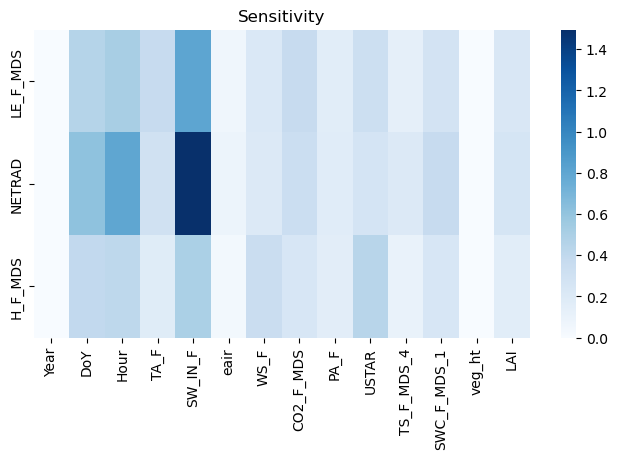

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_sensitivity(data.sensitivity.T, ylabels=x_vars, xlabels=y_vars)
ax.set(title='Sensitivity')


array([12, 13, 12])

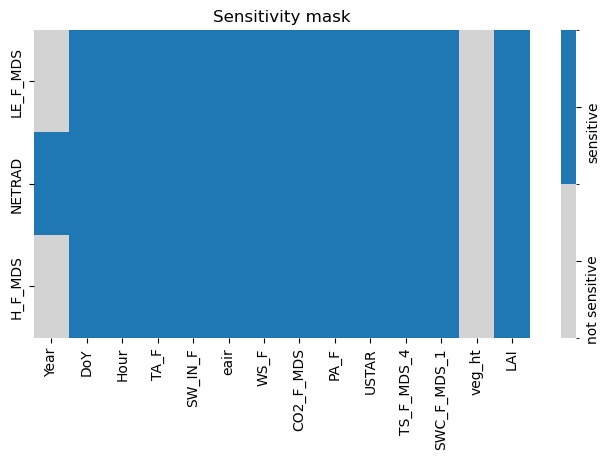

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_sensitivity_mask(data.sensitivity_mask.T, ylabels=x_vars, xlabels=y_vars)
ax.set(title='Sensitivity mask')
data.sensitivity_mask.sum(axis=0)


array([10, 13, 12])

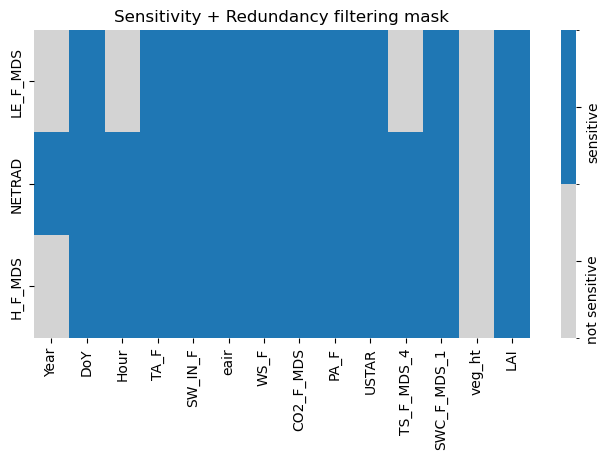

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_sensitivity_mask(data.cond_sensitivity_mask.T, ylabels=x_vars, xlabels=y_vars)
ax.set(title='Sensitivity + Redundancy filtering mask')
data.cond_sensitivity_mask.sum(axis=0)


# Load the mapping results

In [12]:
f_kim_save1 = dir_case / "results/map_many2many"
f_kim_save2 = dir_case / "results/map_many2one"
f_kim_save3 = dir_case / "results/map_many2one_cond"


In [13]:
# Initialize three diffferent KIMs
kim1 = KIM(data, map_configs={}, map_option='many2many')
kim2 = KIM(data, map_configs={}, mask_option="sensitivity", map_option='many2one')
kim3 = KIM(data, map_configs={}, mask_option="cond_sensitivity", map_option='many2one')

# Load the trained mappings
kim1.load(f_kim_save1)
kim2.load(f_kim_save2)
kim3.load(f_kim_save3)


In [14]:
print(np.mean([loss[-1] for loss in kim1.maps[0].loss_val_ens]))
print(np.mean([loss[-1] for loss in kim2.maps[0].loss_val_ens]))
print(np.mean([loss[-1] for loss in kim3.maps[0].loss_val_ens]))
# kims = [kim1, kim2, kim3]


0.00094228203
0.0007951368
0.0010870785


In [15]:
# Calculate the performance metrics
kims = [kim1, kim2, kim3]
labels = ['kim1', 'kim2', 'kim3']
results = {}
for i,kim in enumerate(kims):
    label = labels[i]
    results[label] = kim.evaluate_maps_on_givendata()

# y_ens_train_set, y_ens_test_set, y_mw_train_set, y_mw_test_set, y_true_train_set, y_true_test_set, \
#     rmse_train_set, rmse_test_set, mkge_train_set, mkge_test_set = \
#     [], [], [], [], [], [], [], [], [], []
# for kim in kims:
#     y_ens_train, y_ens_test, y_mw_train, y_mw_test, rmse_train, \
#         y_true_train, y_true_test, rmse_test, mkge_train, mkge_test = kim1.evaluate_maps_on_givendata()
#     y_ens_train_set.append(y_ens_train)
#     y_ens_test_set


# Plot the training results

## Prediction versus true

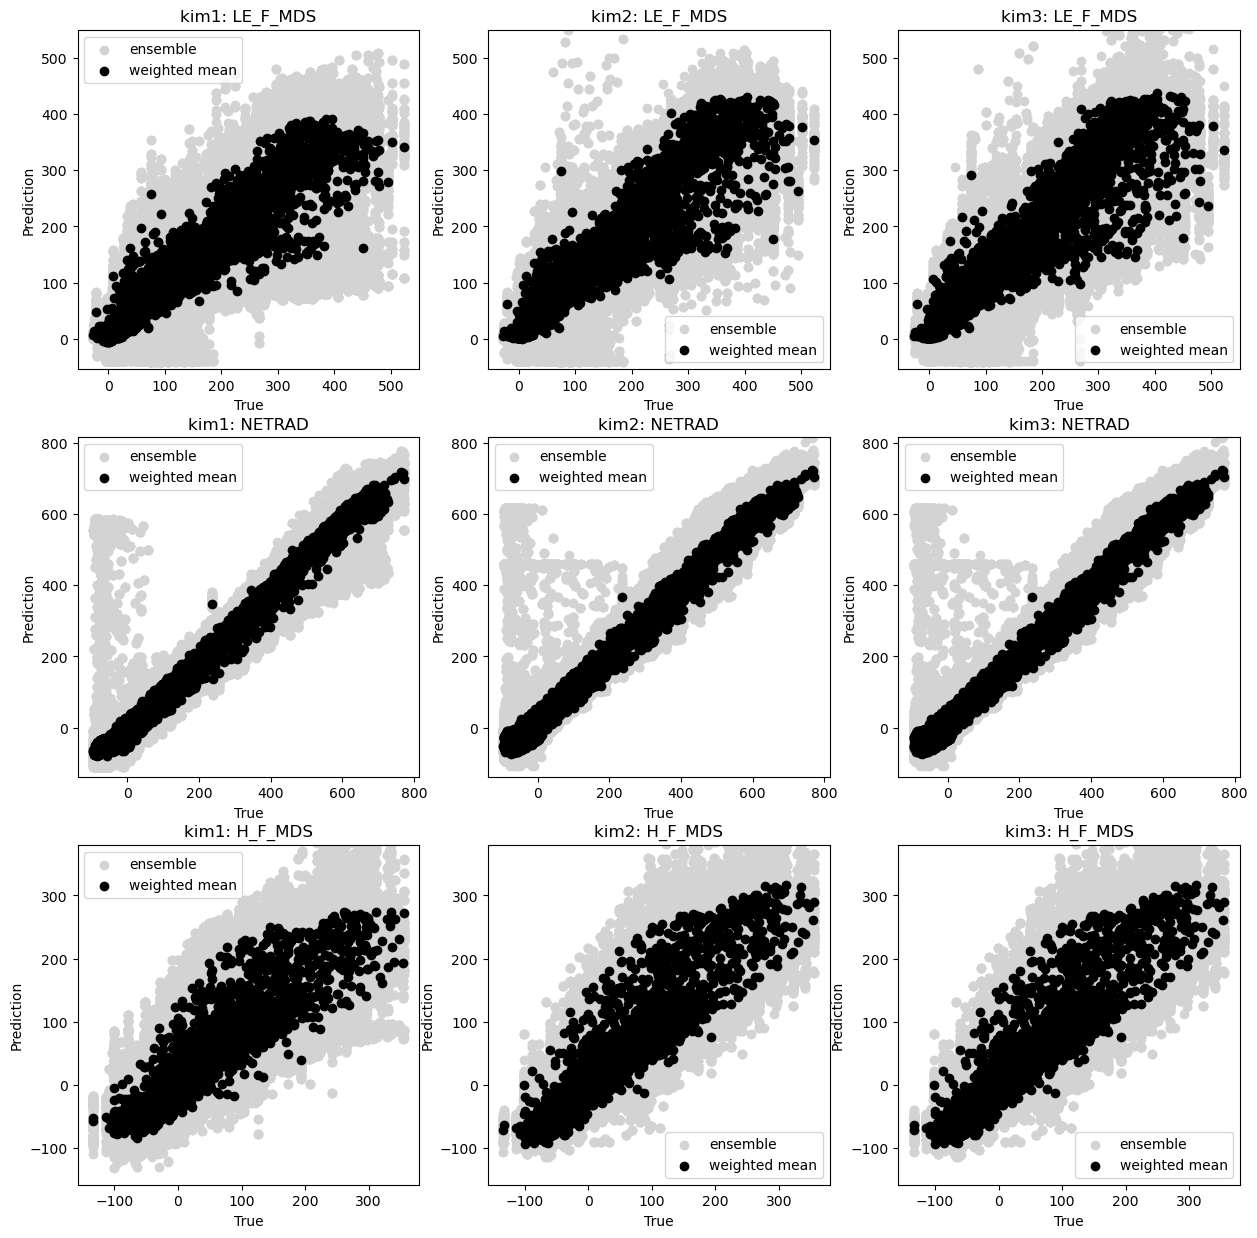

In [17]:
train_or_test = 'test'
fig, axes = plt.subplots(len(y_vars),3,figsize=(15,15))
for i in range(len(y_vars)):
    y_var = y_vars[i]
    for j in range(3):
        model = labels[j]
        r = results[model]
        ax = axes[i,j]
        for k in range(100):
            ax.scatter(r['true'][train_or_test][...,i], r['ens predict'][train_or_test][k,...,i], 
                       color='lightgrey', label='ensemble' if k ==0 else None)
        ax.scatter(r['true'][train_or_test][...,i], r['weighted mean predict'][train_or_test][...,i], 
                   color='black', label='weighted mean')
        lim = ax.get_xlim()
        ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{model}: {y_var}")
        ax.legend()


## Performance versus true (with uncertainty)

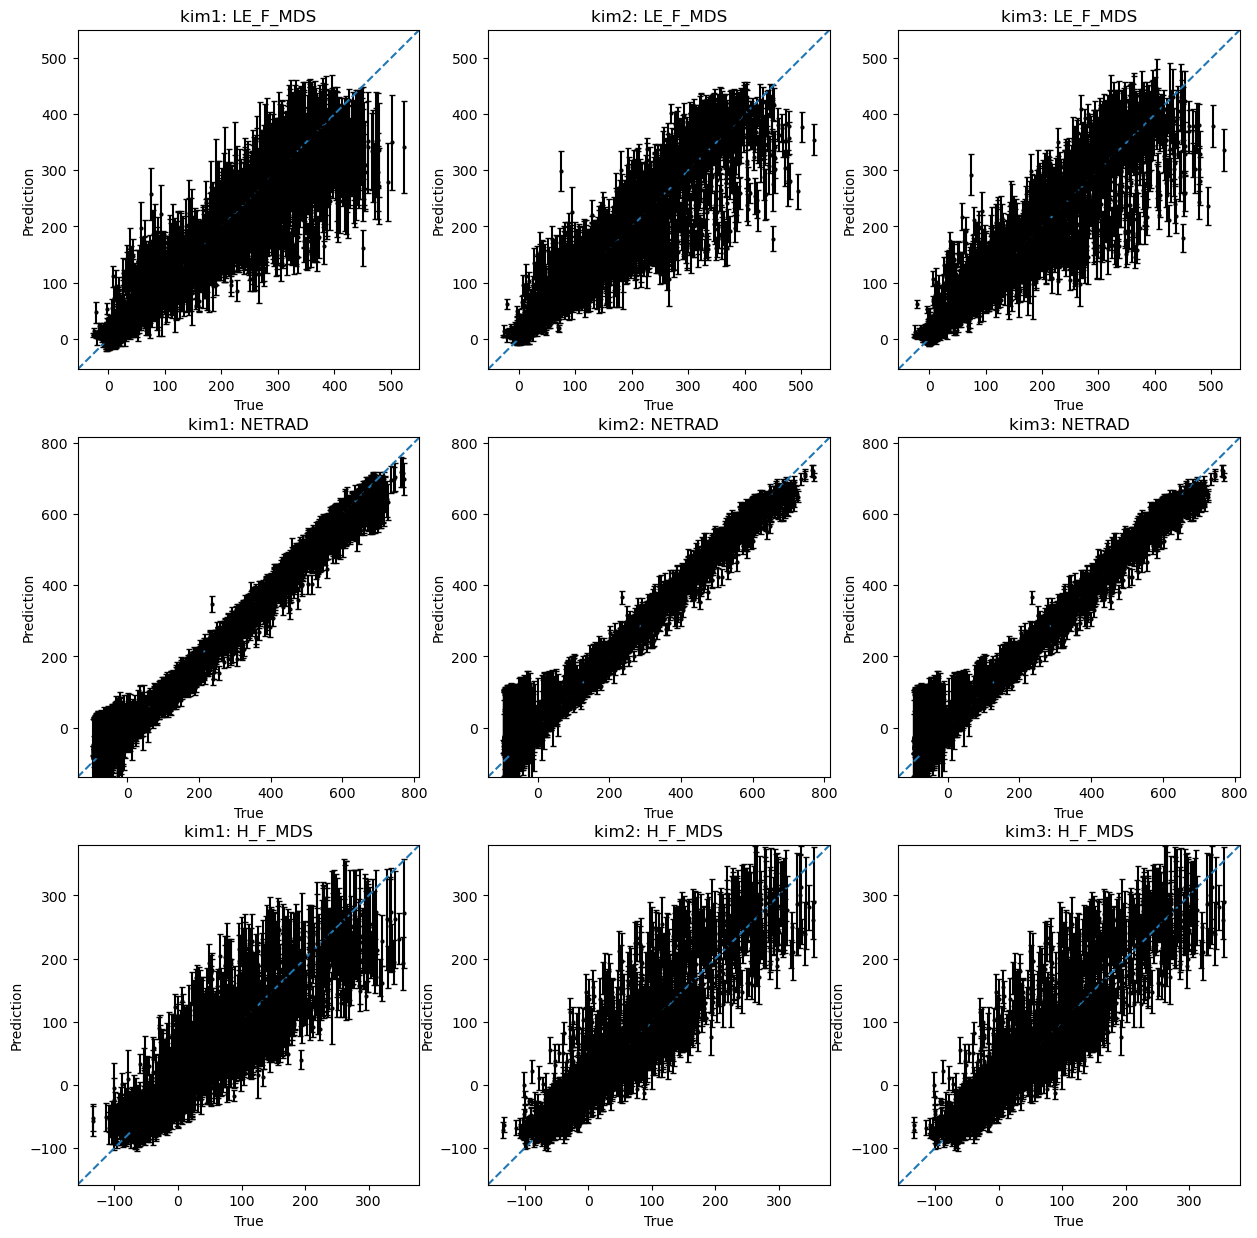

In [18]:
train_or_test = 'test'
fig, axes = plt.subplots(len(y_vars),3,figsize=(15,15))
for i in range(len(y_vars)):
    y_var = y_vars[i]
    for j in range(3):
        model = labels[j]
        r = results[model]
        ax = axes[i,j]
        x = r['true'][train_or_test][...,i]
        y = r['weighted mean predict'][train_or_test][...,i]
        yens = r['ens predict'][train_or_test][...,i]
        w = r['weights'][...,i]
        std = np.sqrt(np.average((yens-y)**2, weights=w, axis=0))
        ax.errorbar(x, y, std, color='black', linestyle='None', fmt='o', markersize=2, capsize=2)
        lim = ax.get_xlim()
        ax.plot(lim, lim, '--', color='tab:blue')
        ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{model}: {y_var}")
